In [1]:
# 1. Các thư viện cần thiết
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('../../Datasets/INTC Historical Data.csv')
df = df[['Open']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [3]:
df.describe()

,Open
count,1624.000000
mean,46.641127
std,10.002370
min,24.730000
25%,37.210000
50%,48.135000
75%,53.800000
max,68.200000


In [4]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Open'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3300.582, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3313.846, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3313.222, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3313.262, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3312.131, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3315.343, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3315.897, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3301.909, Time=0.51 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3301.936, Time=0.78 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3315.220, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3311.271, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3310.801, Time=0.22 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3298.895, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [5]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Open'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Open'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [6]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[55.31166555 55.26001735 55.29488481 55.31648278 55.27013005 55.28346282
 55.31548832 55.28103421 55.27667577 55.31052423 55.29059186 55.27438289
 55.3035996  55.29751455 55.27569629 55.29649052 55.3013453  55.27935089
 55.29049571 55.30230014 55.28403441 55.28634594 55.30103703 55.28863083
 55.28423892 55.29841383 55.29235968 55.28395767 55.29528053 55.29481648]


In [7]:
# 7. Đánh giá độ chính xác validate, test
def mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Regression metrics
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_mape = mape(y_test, y_pred)

valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
valid_mse = mean_squared_error(y_val, y_pred_val)
valid_mae = mean_absolute_error(y_val, y_pred_val)
valid_mape = mape(y_val, y_pred_val)

print('Testing RMSE:', test_rmse)
# print('Testing MSE:', test_mse)
print('Testing MAE:', test_mae)
print("Testing MAPE:", test_mape)

print('Validation RMSE:', valid_rmse)
# print('Validation MSE:', valid_mse)
print('Validation MAE:', valid_mae)
print("Validation MAPE:", valid_mape)

Testing RMSE: 12.927825701439648
Testing MAE: 9.797502919403177
Testing MAPE: 26.94516933355311
Validation RMSE: 26.332350737758105
Validation MAE: 26.256276768855003
Validation MAPE: 91.33188250527543


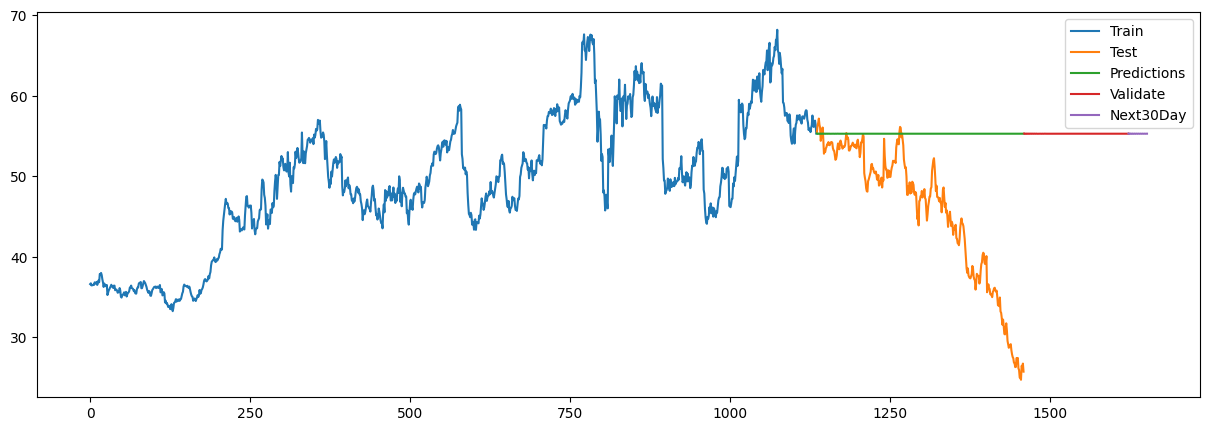

In [8]:
# 9.Vẽ hình
plt.figure(figsize=(15, 5))
plt.plot(train_data.index, train_data['Open'])
plt.plot(test_data.index, test_data['Open'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

In [9]:
test_data.index

RangeIndex(start=1136, stop=1460, step=1)